In [30]:
import numpy as np
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline,splrep, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import empymod
import discretize
import  os

In [31]:
import torch
import torch.nn.functional as F
from torch.autograd.functional import jacobian
eps = torch.finfo(torch.float32).eps
print(eps)

1.1920928955078125e-07


In [32]:
from masa_utils import PsuedoLog
from masa_utils_pytorch import InducedPolarizationSimulation
from masa_utils_pytorch import Pelton, ColeCole, Debye_Sum_Ser_f, Debye_Sum_Par_f
from masa_utils_pytorch import Optimization

# Observation uses Cole-Cole model

In [33]:
#pelton model
tau_true=0.1
parm_true = torch.tensor([np.log(0.2), 0.50, np.log(tau_true), 0.5], dtype=torch.float) #, requires_grad=False)
# inital reference model
np_mvec_true = parm_true.detach().numpy()# cole model


In [34]:
nfreq = 71
freqstrt_log = -2
freqend_log = 5
freq = np.logspace(-2, 5, nfreq)

freq_plot = freq
print(freq.shape)
print(freq)

(71,)
[1.00000000e-02 1.25892541e-02 1.58489319e-02 1.99526231e-02
 2.51188643e-02 3.16227766e-02 3.98107171e-02 5.01187234e-02
 6.30957344e-02 7.94328235e-02 1.00000000e-01 1.25892541e-01
 1.58489319e-01 1.99526231e-01 2.51188643e-01 3.16227766e-01
 3.98107171e-01 5.01187234e-01 6.30957344e-01 7.94328235e-01
 1.00000000e+00 1.25892541e+00 1.58489319e+00 1.99526231e+00
 2.51188643e+00 3.16227766e+00 3.98107171e+00 5.01187234e+00
 6.30957344e+00 7.94328235e+00 1.00000000e+01 1.25892541e+01
 1.58489319e+01 1.99526231e+01 2.51188643e+01 3.16227766e+01
 3.98107171e+01 5.01187234e+01 6.30957344e+01 7.94328235e+01
 1.00000000e+02 1.25892541e+02 1.58489319e+02 1.99526231e+02
 2.51188643e+02 3.16227766e+02 3.98107171e+02 5.01187234e+02
 6.30957344e+02 7.94328235e+02 1.00000000e+03 1.25892541e+03
 1.58489319e+03 1.99526231e+03 2.51188643e+03 3.16227766e+03
 3.98107171e+03 5.01187234e+03 6.30957344e+03 7.94328235e+03
 1.00000000e+04 1.25892541e+04 1.58489319e+04 1.99526231e+04
 2.51188643e+04 3.

In [35]:
IP_model = Pelton(freq=freq)
sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")

In [36]:
dobs_clean=sim.dpred(parm_true).detach()
f_abs = abs(IP_model.f(parm_true)).detach().numpy()
print(f_abs.max(),f_abs.min())
relative_error = torch.tensor(0.02)

noise_floor = torch.tensor(f_abs.max() * 1e-3)
torch.random.seed()
dobs =  dobs_clean + torch.rand(len(dobs_clean)) * torch.sqrt(
        (relative_error * abs(dobs_clean))**2 
        + (noise_floor*torch.ones(len(dobs_clean)))**2
    )

0.19449106 0.10028248


# But Invert using pelton model

In [37]:
IP_model = ColeCole(freq=freq,res=True)
sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")
parm_init = torch.tensor([np.log(5.0), 0.1, np.log(0.04), 0.6], dtype=torch.float32, requires_grad=True) #, requires_grad=False)

In [38]:
opt = Optimization(sim=sim, dobs=dobs)
Wd =opt.get_Wd(ratio=relative_error, plateau=noise_floor)
# opt.Wd = torch.diag(torch.ones(len(dobs)))
opt.Ws = torch.eye(4)

In [39]:
print(torch.diag(opt.Wd))

tensor([ 256.5027,  255.7028,  258.3904,  255.3780,  258.0024,  260.1708,
         261.8465,  263.5294,  265.0753,  267.1329,  271.1668,  272.7863,
         276.5081,  279.7194,  280.8861,  289.9927,  294.7775,  296.8777,
         303.9637,  306.8139,  312.5977,  325.2086,  332.1744,  339.6958,
         345.3282,  351.2837,  362.9324,  370.1619,  378.2314,  386.9727,
         396.1375,  404.0918,  407.4386,  412.7251,  423.8051,  428.0525,
         434.9332,  437.3822,  448.4572,  450.4167,  453.8374,  457.1659,
         456.3369,  460.1469,  468.1646,  470.8943,  468.7419,  470.7906,
         476.7074,  475.5675,  482.2443,  478.8224,  482.4576,  482.5556,
         484.9609,  485.4428,  484.0940,  484.1350,  491.9407,  489.3145,
         485.6312,  487.8175,  490.4664,  493.8977,  487.0014,  490.7634,
         491.3405,  489.4785,  487.7658,  492.1885,  496.0260, 4608.4785,
        4481.6094, 4362.3389, 4249.8086, 4086.2903, 3965.8530, 3783.3896,
        3670.9812, 3496.9954, 3344.583

In [40]:
niter = 200
stol=1e-6
coolingFactor = 2.0
coolingRate = 2
mu=1e-3
beta0_ratio = 1

In [41]:
models_rec = []
dpreds = []
errors_prg = []
models_prg = []
dinit_refs = []

In [42]:
beta0 = opt.BetaEstimate_byEig(
    m=parm_init,norm=False, update_Wsen=True, beta0_ratio=beta0_ratio)
print(beta0)
mpred = opt.GradientDescent(stol=stol,l1reg=True,
coolingFactor=coolingFactor, coolingRate=coolingRate,mu=mu,
    mvec_init=parm_init,niter=niter,beta0=beta0,
    update_Wsen=True,ELS=True, BLS=True)
dinit_refs.append(opt.dpred(parm_init))
models_rec.append(mpred)
dpreds.append(opt.dpred(mpred))
errors_prg.append(opt.error_prg)
models_prg.append(opt.mvec_prg)

tensor(8.2491e+08)


  1, beta:8.2e+08, step:9.5e-07, gradient:2.2e+05,  f:6.5e+04
  2, beta:8.2e+08, step:9.5e-07, gradient:1.1e+09,  f:3.3e+06
  3, beta:4.1e+08, step:1.9e-06, gradient:5.6e+08,  f:6.9e+04
  4, beta:4.1e+08, step:9.5e-07, gradient:5.6e+08,  f:8.6e+05
  5, beta:2.1e+08, step:1.9e-06, gradient:2.8e+08,  f:6.8e+04
  6, beta:2.1e+08, step:9.5e-07, gradient:2.8e+08,  f:2.6e+05
  7, beta:1.0e+08, step:1.9e-06, gradient:1.4e+08,  f:6.7e+04
  8, beta:1.0e+08, step:9.5e-07, gradient:1.4e+08,  f:1.1e+05
  9, beta:5.2e+07, step:1.9e-06, gradient:7.0e+07,  f:6.6e+04
 10, beta:5.2e+07, step:9.5e-07, gradient:7.0e+07,  f:7.6e+04
 11, beta:2.6e+07, step:1.9e-06, gradient:3.5e+07,  f:6.5e+04
 12, beta:2.6e+07, step:9.5e-07, gradient:3.5e+07,  f:6.7e+04
 13, beta:1.3e+07, step:1.9e-06, gradient:1.8e+07,  f:6.5e+04
 14, beta:1.3e+07, step:9.5e-07, gradient:1.7e+07,  f:6.5e+04
 15, beta:6.4e+06, step:1.9e-06, gradient:9.0e+06,  f:6.5e+04
 16, beta:6.4e+06, step:9.5e-07, gradient:8.6e+06,  f:6.5e+04
 17, bet

In [43]:
np_mvec_prg = opt.mvec_prg
np_mvec_init = parm_init.detach().numpy()
np_mvec_true = parm_true.detach().numpy()
np_mvec_est = mpred.detach().numpy()
dest = opt.dpred(mpred)

In [44]:
print("Note we are using Cole-Cole model for simulation")
print(f"initial :{np.exp(np_mvec_init[0]):.3e}, {np_mvec_init[1]:3f}, {np.exp(np_mvec_init[2]):.3e}, {np_mvec_init[3]:.3f}")
print(f"est     :{np.exp(np_mvec_est[0]):.3e}, { np_mvec_est[1]:3f}, { np.exp(np_mvec_est[2]):.3e}, { np_mvec_est[3]:.3f}")

print("But we are using Pelton model for observation")
print(f"est     :{np.exp(-np_mvec_est[0])/(1.0-np_mvec_est[1]):.3e}, { np_mvec_est[1]:3f}, { np.exp(np_mvec_est[2]):.3e}, { np_mvec_est[3]:.3f}")
print(f"true    :{np.exp(np_mvec_true[0]):.3e}, {np_mvec_true[1]:3f}, {np.exp(np_mvec_true[2]):.3e}, {np_mvec_true[3]:.3f}")


Note we are using Cole-Cole model for simulation
initial :5.000e+00, 0.100000, 4.000e-02, 0.600
est     :9.732e+00, 0.486311, 3.019e-02, 0.511
But we are using Pelton model for observation
est     :2.000e-01, 0.486311, 3.019e-02, 0.511
true    :2.000e-01, 0.500000, 1.000e-01, 0.500


In [45]:
eta = np_mvec_true[1]
c = np_mvec_true[3]
taup = np.exp(np_mvec_true[2])
tauc = np.exp(np_mvec_est[2])
print((1-eta)*(taup**c))
print((tauc**c))

0.15811388194561005
0.17374936


# Invert Debye-Sum Series

In [46]:
ntau=10
taus = np.logspace(-5,2,ntau)
print(taus)

[1.00000000e-05 5.99484250e-05 3.59381366e-04 2.15443469e-03
 1.29154967e-02 7.74263683e-02 4.64158883e-01 2.78255940e+00
 1.66810054e+01 1.00000000e+02]


In [47]:
IP_model = Debye_Sum_Ser_f(freq=freq, taus=taus)
sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")

In [48]:
parm_init = torch.tensor(
    np.r_[np.log(0.22), np.zeros(ntau)],
    dtype=torch.float32,
    requires_grad=True
) #, requires_grad=False)


In [49]:
opt = Optimization(sim=sim, dobs=dobs)
Wd =opt.get_Wd(ratio=relative_error, plateau=noise_floor)
opt.Ws = torch.eye(len(parm_init))
beta0 = opt.BetaEstimate_byEig(
    m=parm_init,norm=False, update_Wsen=True, beta0_ratio=beta0_ratio)

In [50]:
beta0 = opt.BetaEstimate_byEig(
    m=parm_init,norm=False, update_Wsen=True, beta0_ratio=beta0_ratio)
print(beta0)
mpred = opt.GradientDescent(stol=stol,l1reg=True,
coolingFactor=coolingFactor, coolingRate=coolingRate,mu=mu,
    mvec_init=parm_init,niter=niter,beta0=beta0,
    update_Wsen=True,ELS=True, BLS=True)
dinit_refs.append(opt.dpred(parm_init))
models_rec.append(mpred)
dpreds.append(opt.dpred(mpred))
errors_prg.append(opt.error_prg)
models_prg.append(opt.mvec_prg)

tensor(35675040.)
  1, beta:3.6e+07, step:9.5e-07, gradient:1.1e+06,  f:9.7e+04
  2, beta:3.6e+07, step:3.8e-06, gradient:8.8e+07,  f:9.7e+04
  3, beta:1.8e+07, step:9.5e-07, gradient:7.8e+06,  f:9.8e+04
  4, beta:1.8e+07, step:3.1e-05, gradient:4.4e+07,  f:9.8e+04
  5, beta:8.9e+06, step:9.5e-07, gradient:3.9e+06,  f:9.8e+04
  6, beta:8.9e+06, step:3.1e-05, gradient:2.2e+07,  f:9.7e+04
  7, beta:4.5e+06, step:9.5e-07, gradient:2.5e+06,  f:9.7e+04
  8, beta:4.5e+06, step:6.1e-05, gradient:1.0e+07,  f:9.7e+04
  9, beta:2.2e+06, step:9.5e-07, gradient:1.3e+06,  f:9.7e+04
 10, beta:2.2e+06, step:1.2e-04, gradient:4.7e+06,  f:9.7e+04
 11, beta:1.1e+06, step:9.5e-07, gradient:1.3e+06,  f:9.7e+04
 12, beta:1.1e+06, step:3.1e-05, gradient:2.1e+06,  f:9.7e+04
 13, beta:5.6e+05, step:9.5e-07, gradient:1.0e+06,  f:9.7e+04
 14, beta:5.6e+05, step:1.0e+00, gradient:6.8e+05,  f:9.7e+04
 15, beta:2.8e+05, step:5.0e-01, gradient:8.0e+05,  f:8.4e+04
 16, beta:2.8e+05, step:1.0e+00, gradient:4.2e+05,  

# Invert Debye-Sum Parallel 

In [51]:
IP_model = Debye_Sum_Par_f(freq=freq, taus=taus, res=True)
sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")

In [52]:
parm_init = torch.tensor(
    np.r_[np.log(5.0), np.zeros(ntau)],
    dtype=torch.float32,
    requires_grad=True
) #, requires_grad=False)


In [53]:
opt = Optimization(sim=sim, dobs=dobs)
Wd =opt.get_Wd(ratio=relative_error, plateau=noise_floor)
opt.Ws = torch.eye(len(parm_init))


In [54]:
beta0 = opt.BetaEstimate_byEig(
    m=parm_init,norm=False, update_Wsen=True, beta0_ratio=beta0_ratio)
print(beta0)
mpred = opt.GradientDescent(stol=stol,l1reg=True,
coolingFactor=coolingFactor, coolingRate=coolingRate,mu=mu,
    mvec_init=parm_init,niter=niter,beta0=beta0,
    update_Wsen=True,ELS=True, BLS=True)
dinit_refs.append(opt.dpred(parm_init))
models_rec.append(mpred)
dpreds.append(opt.dpred(mpred))
errors_prg.append(opt.error_prg)
models_prg.append(opt.mvec_prg)

tensor(2.8244e+08)
  1, beta:2.8e+08, step:9.5e-07, gradient:3.9e+05,  f:7.6e+04
  2, beta:2.8e+08, step:9.5e-07, gradient:5.0e+08,  f:8.1e+04
  3, beta:1.4e+08, step:9.5e-07, gradient:6.0e+07,  f:8.1e+04
  4, beta:1.4e+08, step:3.8e-06, gradient:2.5e+08,  f:7.7e+04
  5, beta:7.1e+07, step:9.5e-07, gradient:3.0e+07,  f:7.8e+04
  6, beta:7.1e+07, step:7.6e-06, gradient:1.2e+08,  f:7.7e+04
  7, beta:3.5e+07, step:9.5e-07, gradient:1.5e+07,  f:7.6e+04
  8, beta:3.5e+07, step:9.5e-07, gradient:6.2e+07,  f:7.6e+04
  9, beta:1.8e+07, step:9.5e-07, gradient:7.7e+06,  f:7.6e+04
 10, beta:1.8e+07, step:7.6e-06, gradient:3.1e+07,  f:7.6e+04
 11, beta:8.8e+06, step:9.5e-07, gradient:3.9e+06,  f:7.6e+04
 12, beta:8.8e+06, step:1.9e-06, gradient:1.5e+07,  f:7.6e+04
 13, beta:4.4e+06, step:9.5e-07, gradient:1.7e+06,  f:7.6e+04
 14, beta:4.4e+06, step:3.8e-06, gradient:7.6e+06,  f:7.6e+04
 15, beta:2.2e+06, step:9.5e-07, gradient:8.2e+05,  f:7.6e+04
 16, beta:2.2e+06, step:3.8e-06, gradient:3.6e+06, 

In [55]:
nref= 3

In [56]:
dest_abs_np =[]
dest_phase_np =[]
dest_real_np =[]
dest_imag_np =[]
dinit_abs_np =[]
dinit_phase_np =[]
mpred_np =[]
for i in range(nref):
    mpred_np.append(models_rec[i].detach().numpy())
    dest = dpreds[i].detach().numpy()
    dinit = dinit_refs[i].detach().numpy()
    dest_real = dest[:nfreq]
    dest_imag = dest[nfreq:]
    dinit_real = dinit[:nfreq]
    dinit_imag = dinit[nfreq:]
    dest_abs = np.abs(dest_real + 1j * dest_imag)
    dest_phase = np.angle(dest_real + 1j * dest_imag, deg=True)
    dinit_abs = np.abs(dinit_real + 1j * dinit_imag) 
    dinit_phase = np.angle(dinit_real + 1j * dinit_imag, deg=True)
    dest_real_np.append(dest_real)
    dest_imag_np.append(dest_imag)
    dest_abs_np.append(dest_abs)
    dest_phase_np.append(dest_phase)
    dinit_abs_np.append(dinit_abs)
    dinit_phase_np.append(dinit_phase)
dobs_np = dobs.detach().numpy()
dobs_real = dobs_np[:nfreq]
dobs_imag = dobs_np[nfreq:]
dobs_abs = np.abs(dobs_real + 1j * dobs_imag)
dobs_phase = np.angle(dobs_real + 1j * dobs_imag, deg=True)


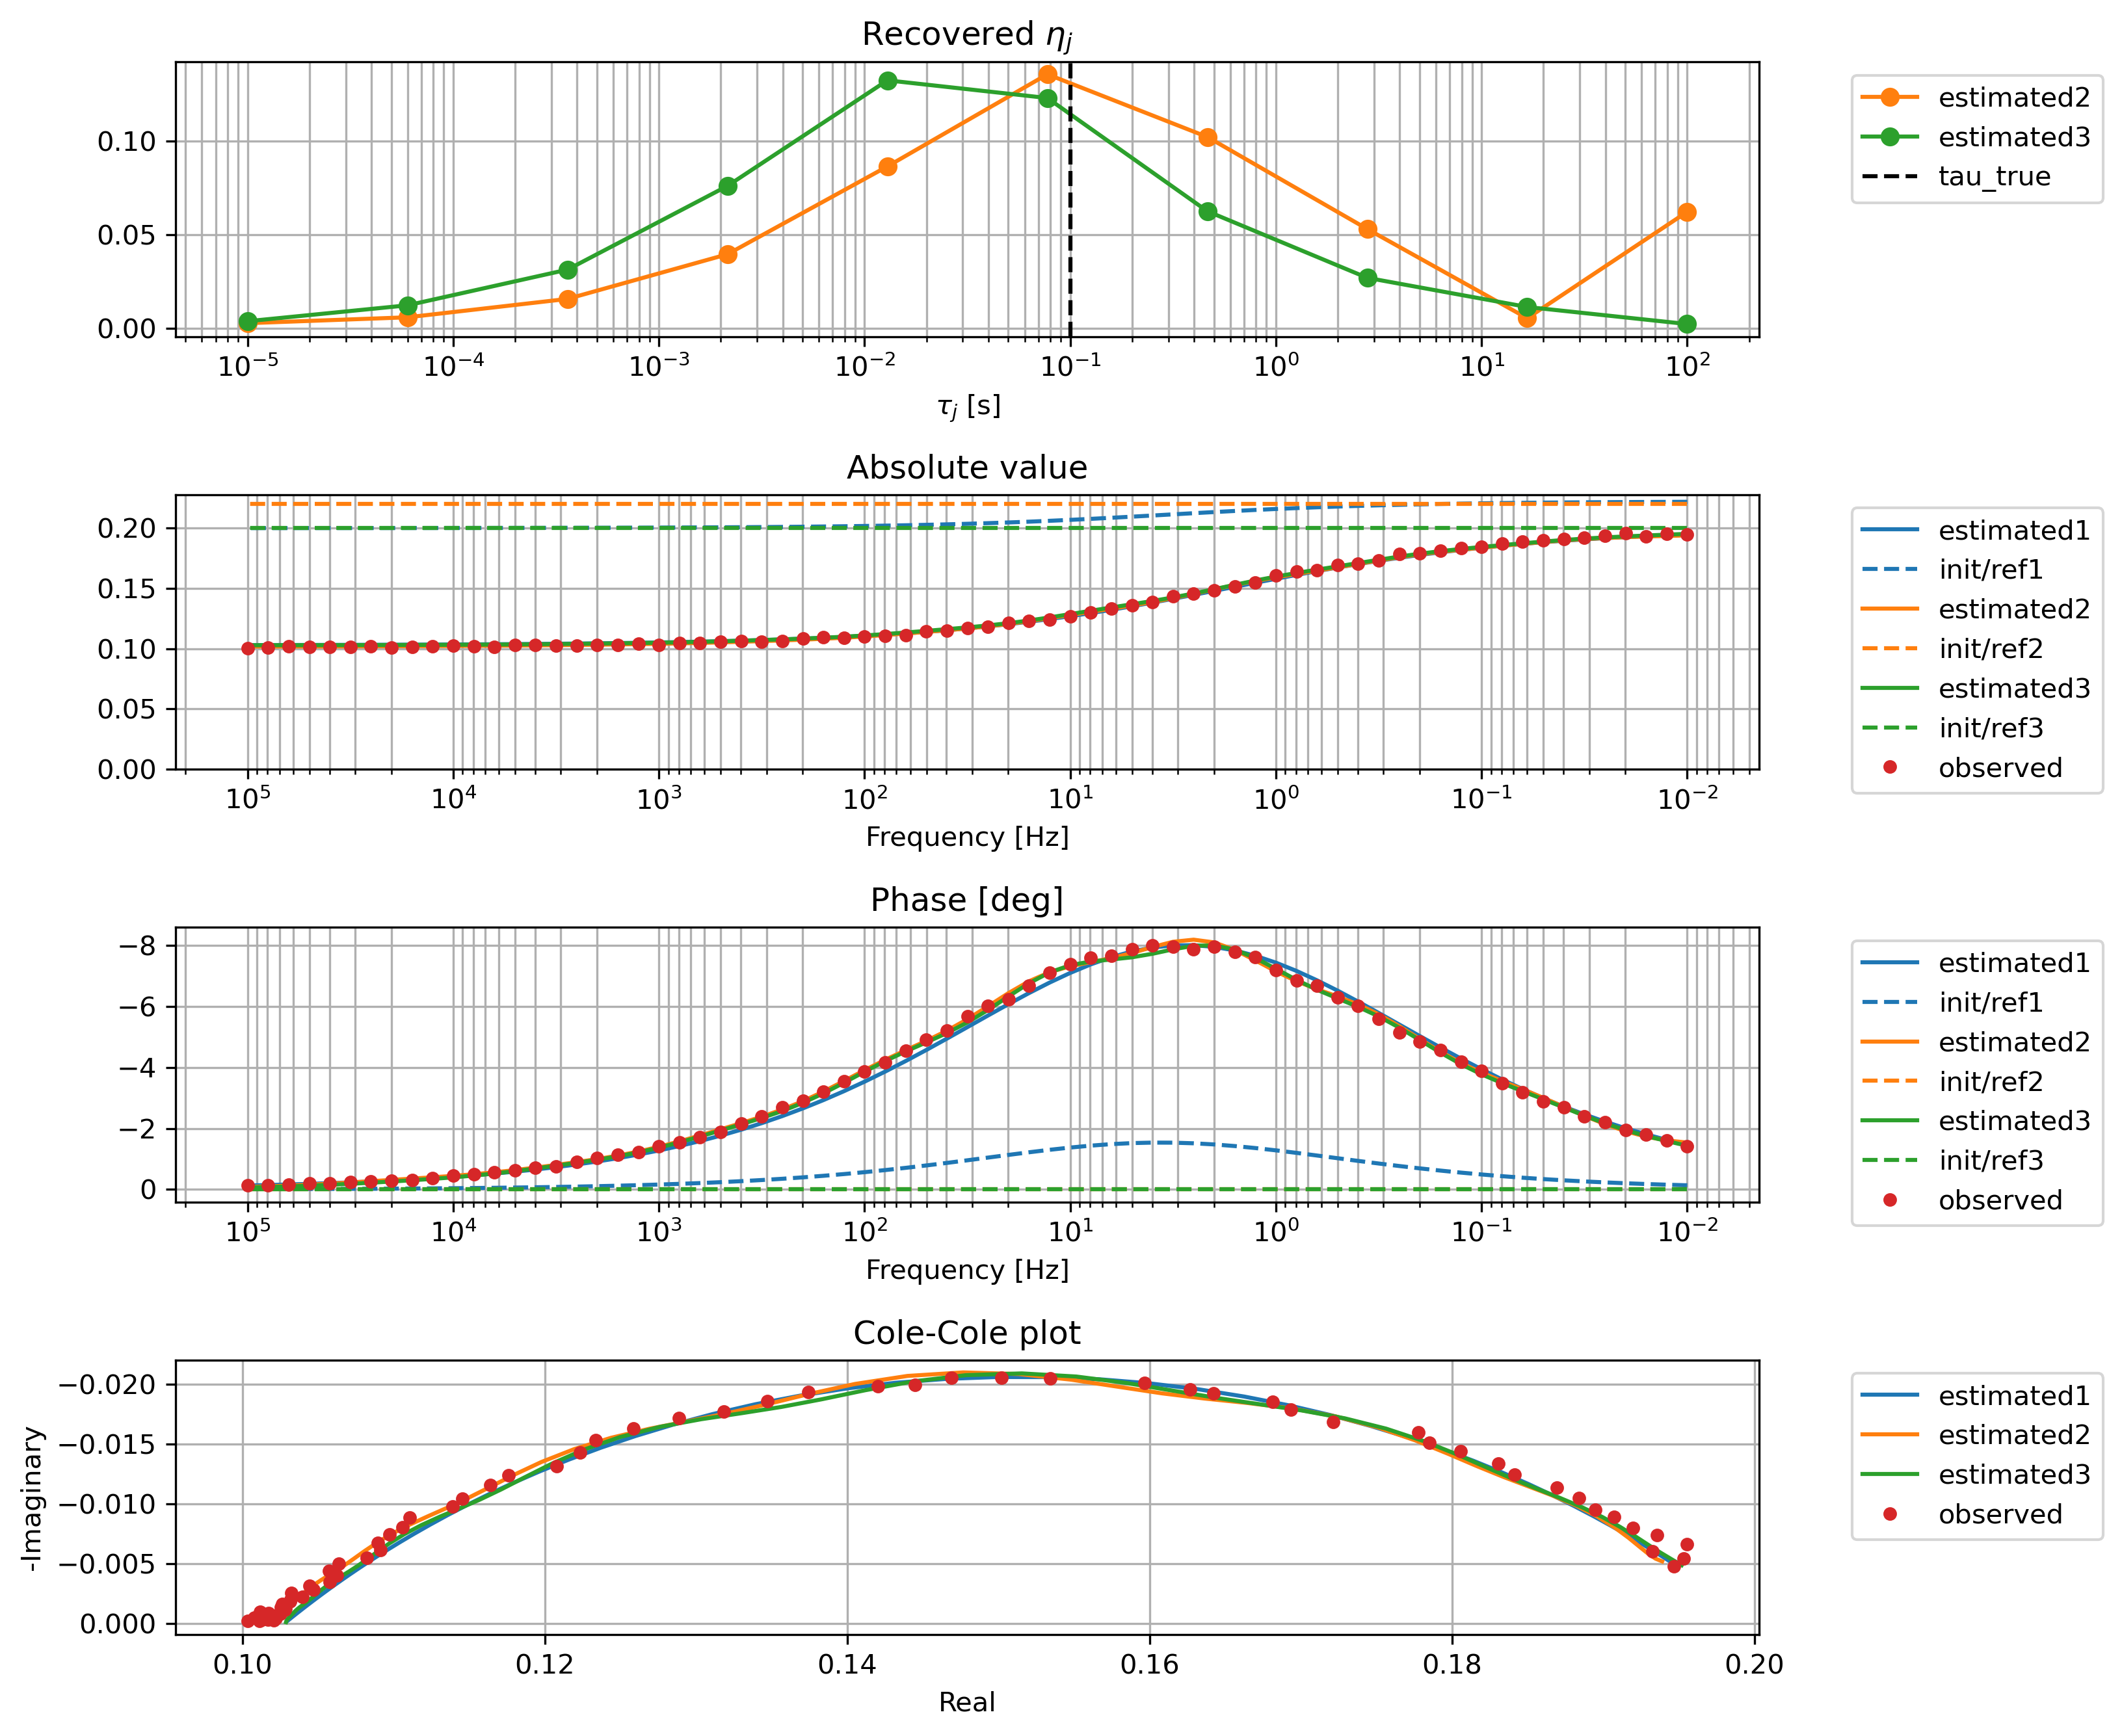

In [65]:
fig, ax = plt.subplots(4, 1, figsize=(11,9),dpi=300)
for i in range(nref):
    dest_abs = dest_abs_np[i]
    dest_phase = dest_phase_np[i]
    dest_real = dest_real_np[i]
    dest_imag = dest_imag_np[i]
    dinit_abs = dinit_abs_np[i] 
    dinit_phase = dinit_phase_np[i]
    mpred_plot = mpred_np[i]
    if i !=0:
        ax[0].semilogx(taus, mpred_plot[1:1+ntau], color=f"C{i}",  marker="o",label=f"estimated{i+1}")
    ax[1].semilogx(freq_plot, dest_abs, color=f"C{i}", label=f"estimated{i+1}")
    ax[1].semilogx(freq_plot, dinit_abs, color=f"C{i}", linestyle="--", label=f"init/ref{i+1}")
    ax[2].semilogx(freq_plot, dest_phase, color=f"C{i}", label=f"estimated{i+1}")
    ax[2].semilogx(freq_plot, dinit_phase, color=f"C{i}", linestyle="--", label=f"init/ref{i+1}")
    ax[3].plot(dest_real, dest_imag, color=f"C{i}", label=f"estimated{i+1}")
ax[0].axvline(x=tau_true, color="k", linestyle="--", label="tau_true")
ax[1].semilogx(freq_plot, dobs_abs, color=f"C{nref}", linestyle="",markersize=4.0, marker="o", label="observed")
ax[1].set_ylim(bottom=0)
ax[1].invert_xaxis()
ax[2].semilogx(freq_plot, dobs_phase, color=f"C{nref}", linestyle="",markersize=4.0, marker="o", label="observed")
ax[2].invert_xaxis()
ax[2].invert_yaxis()
ax[3].plot(dobs_real, dobs_imag, color=f"C{nref}", linestyle="",markersize=4.0, marker="o", label="observed")
ax[3].invert_yaxis()

for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_xlabel(r"$\tau_j$ [s]")
ax[0].set_title(r"Recovered $\eta_j$")
ax[1].set_title("Absolute value")
ax[2].set_title("Phase [deg]")
ax[3].set_title("Cole-Cole plot")
ax[3].set_xlabel("Real")
ax[3].set_ylabel("-Imaginary")
plt.tight_layout()
plt.savefig("41_Pelton_res_sip.jpg", dpi=300)

In [58]:
for i in range(nref):
    if i!= 0:
        mpred_plot = mpred_np[i]
        print(mpred_plot[1:ntau+1].sum())


0.5092301
0.48239467
